In [1]:
import os
os.chdir("..")
from epilearn.models.SpatialTemporal import STGCN, ColaGNN
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast
import torch
import matplotlib.pyplot as plt
import numpy as np


## What your data looks like:

In [2]:
data = torch.load("example.pt")
data.keys()

dict_keys(['features', 'graph', 'dynamic_graph', 'targets', 'states'])

In [3]:
print(f"Node Features[time steps, nodes, channels]: {data['features'].shape}")
print(f"Static Graph[nodes, nodes]: {data['graph'].shape}")
print(f"Dynamic Graph[time steps, nodes, nodes]: {data['dynamic_graph'].shape}")
print(f"Prediction Target[time steps, nodes]: {data['targets'].shape}")
print(f"Nodes States[time steps, nodes]: {data['states'].shape}")

Node Features[time steps, nodes, channels]: torch.Size([539, 47, 4])
Static Graph[nodes, nodes]: (47, 47)
Dynamic Graph[time steps, nodes, nodes]: torch.Size([539, 47, 47])
Prediction Target[time steps, nodes]: torch.Size([539, 47])
Nodes States[time steps, nodes]: torch.Size([539, 47])


In [4]:
node_features = data['features']
static_graph = torch.Tensor(data['graph'])
dynamic_graph = data['dynamic_graph']
targets = data['targets']
node_status = data['states']

In this example, we also use the target time series as one of the channels.

In [5]:
(node_features[:,:, 0] != targets).sum()

tensor(0)

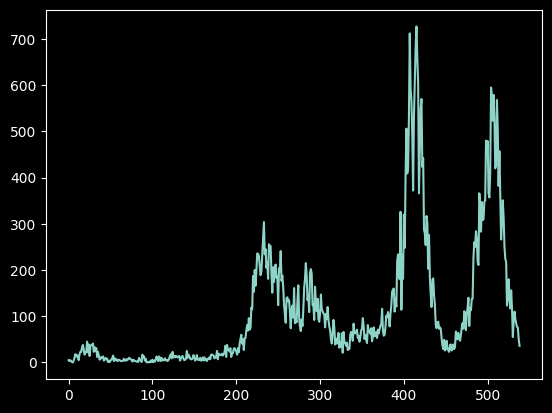

In [6]:
# first feature
plt.plot(np.array(node_features[:,0,0]))

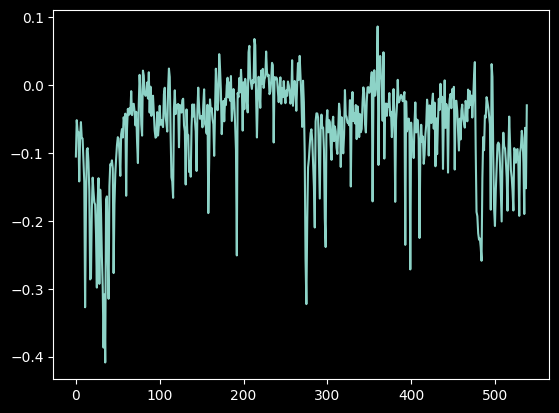

In [7]:
# second feature
plt.plot(np.array(node_features[:,0,1]))

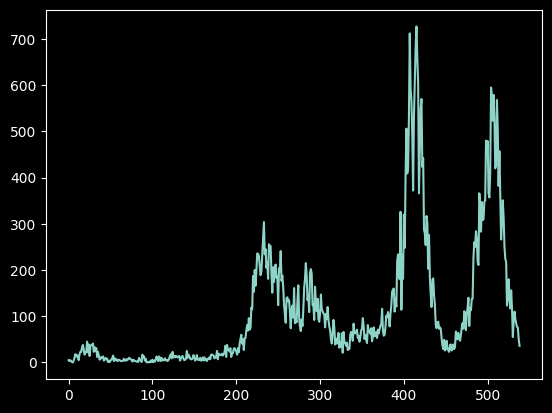

In [8]:
# prediction target
plt.plot(np.array(targets[:,0]))

## Loading your data into Epilearn dataset

Take spatial-temporal task as an example, we need ad least 1. node features; 2. target time series of every node; 3. graph (static or dynamic, depending on the model used)

In [9]:
dataset = UniversalDataset(x=node_features, 
                        #    states=node_status, # e.g. additional information of each node, e.g. SIR states
                           y=targets, # prediction target
                           graph=static_graph, # adjacency matrix, we also support edge index: edge_index = ...
                        #    dynamic_graph=dynamic_graph # # adjacency matrix
                           )

In [10]:
# initialize settings
lookback = 12 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=STGCN,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=2,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          permute_dataset=True)

spatial-temporal model loaded!


 50%|█████     | 1/2 [00:00<00:00,  1.39it/s]

######### epoch:0
Training loss: 0.15750086247440306
Validation loss: 0.7408097982406616


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]



Final Training loss: 0.1027252207540216
Final Validation loss: 0.6346551775932312
Test MSE: 3.6013777256011963
Test MAE: 1.2603527307510376
Test RMSE: 1.8977296352386475


In [11]:
# Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

Test MSE: 0.086558997631073
Test MAE: 0.16699489951133728
Test RMSE: 0.2942090928554535


In [12]:
print(train_evaluation.keys())

dict_keys(['mse', 'mae', 'rmse', 'predictions', 'targets'])


In [13]:
print(train_evaluation['predictions'].shape)
print(train_evaluation['targets'].shape)

torch.Size([309, 47, 3])
torch.Size([309, 47, 3])


In [14]:
# when val_rate > 0
val_evaluation = task.evaluate_model(model=task.model,
                                 features=task.val_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.val_split['dynamic_graph'], 
                                 states=task.val_split['states'], 
                                 targets=task.val_split['targets'])

Test MSE: 0.6346551775932312
Test MAE: 0.5110660791397095
Test RMSE: 0.7966524958610535


In [15]:
test_evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.test_split['dynamic_graph'], 
                                 states=task.test_split['states'], 
                                 targets=task.test_split['targets'])

Test MSE: 3.6013777256011963
Test MAE: 1.2603527307510376
Test RMSE: 1.8977296352386475


### Temporal Task

As an example of temporal forecasting, we use a univariate time series as both feature and the target.

In [16]:
inputs = targets[:,0].unsqueeze(-1)
inputs.shape

torch.Size([539, 1])

In [17]:
dataset = UniversalDataset(x=inputs, y=inputs)

In [18]:
from epilearn.models.Temporal import LSTMModel
# initialize settings
lookback = 12 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=LSTMModel,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=10,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          permute_dataset=True)

temporal model loaded!


  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1, 3])) that is different to the input size (torch.Size([5, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 3])) that is different to the input size (torch.Size([4, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/epilearn/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([94, 1, 3])) that is different to the input size (torch.Size([94, 3])). This will likely lead to i

######### epoch:0
Training loss: 0.2859977081177696
Validation loss: 2.8719751834869385


100%|██████████| 10/10 [00:00<00:00, 14.45it/s]



Final Training loss: 0.2562234279729666
Final Validation loss: 2.8242666721343994
Test MSE: 2.1264398097991943
Test MAE: 1.0264263153076172
Test RMSE: 1.4582316875457764


## Spatial Task

As an example of Spatial detection, we need 1. static graph; 2. node features 3. target of each node

In [19]:
graph = static_graph # nodes, nodes
features = torch.round(torch.rand((10,47,1,4))) # batch, nodes, time steps, channels
node_target = torch.round(torch.rand((10,47))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([47, 47])
features: torch.Size([10, 47, 1, 4])
node_target: torch.Size([10, 47])


Assuming we have binary class labels, and we want to do binary classification on each node

In [20]:
node_target

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.

In [21]:
print(f"node_target: {node_target.shape}")

node_target: torch.Size([10, 47])


In [22]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [23]:
from epilearn.tasks.detection import Detection
from epilearn.models.Spatial.GCN import GCN

lookback = 1 # inputs size
horizon = 2 # predicts size; also seen as number of classes

dataset.transforms = None
task = Detection(prototype=GCN, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

result = task.train_model(dataset=dataset, loss='ce', epochs=5, permute_dataset=False)

spatial model loaded!


100%|██████████| 5/5 [00:00<00:00, 173.27it/s]


######### epoch:0
Training loss: 0.7274734377861023
Validation loss: 0.6974123120307922
######### epoch:1
Training loss: 0.6854868531227112
Validation loss: 0.69781893491745
######### epoch:2
Training loss: 0.7040895223617554
Validation loss: 0.6983151435852051
######### epoch:3
Training loss: 0.6948218941688538
Validation loss: 0.6987905502319336
######### epoch:4
Training loss: 0.6937199831008911
Validation loss: 0.6992425322532654

Final Training loss: 0.6937199831008911
Final Validation loss: 0.6992425322532654
Best Epoch: 0
Best Training loss: 0.7274734377861023
Best Validation loss: 0.6974123120307922

Predicting Progress...


100%|██████████| 2/2 [00:00<00:00, 531.93it/s]

Test ACC: 26.5
